# Uncertainity Estimation and Quantification

Gaussian Processes estimate the uncertanity associated with the prediction. This enables us to quantify the uncertanity associated with actions, when we have multiple possible storm scenarios.

## Generate Raw Data

In [1]:
import baestorm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyswmm_lite import environment

In [2]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y

In [3]:
gaussian_flows = np.vectorize(gaussian_flows)

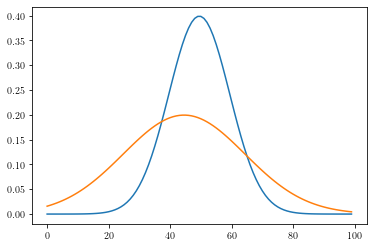

In [4]:
plt.plot(gaussian_flows(np.linspace(-5.0, 5.0, 100)))
plt.plot(gaussian_flows(np.linspace(-5.0, 5.0, 100), -0.5, 2.0))

Looks like flows. Now lets random flows that can be used for the model.

### Random inflows

In [5]:
means = [0.0, -0.1, -0.2, 0.1, 0.2]
sigma = [1.0, 2.0, 0.5, 0.3]

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = gaussian_flows(np.linspace(-5.0, 5.0, 1000), mu, sig)
        count += 1

In [6]:
inflows = pd.DataFrame.from_dict(inflows)

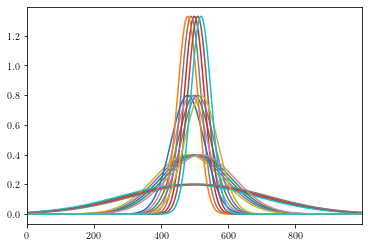

In [7]:
inflows.plot(legend=False)

These random inflows look promising. Let see how they change as they move though the network. 

In [8]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(500))
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()

    return data["outflow"], sum(data["overflow"])

In [9]:
data_flows = {}
for i in inflows.keys():
    flows, _  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows

In [10]:
data_flows = pd.DataFrame.from_dict(data_flows)

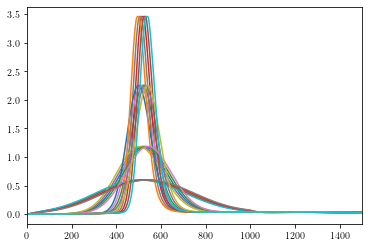

In [11]:
data_flows.plot(legend=False)

Flows though the system look like they are a trasformation of inflows going into the basin. Let take a look at how the GP's are accounting this uncertanity.

## Bayesian Optimization

In [12]:
from GPyOpt.methods import BayesianOptimization

In [13]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 19, 20, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows = single_basin(valves, inflows[str(temp_1)].values)
    # Convert to pandas series for ease of ops
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    # Compute performance
    reward = 0.0
    overflows = overflows.gt(0.0).any()
    if overflows:
        reward += 10**3
    flows = flows.sub(1.5)
    flows[flows < 0.0] = 0.0
    reward += flows.sum()
    return reward

# Set the random seed
np.random.seed(42)

# Define gpopt
domain = [{"name": "var_1", "type": "continuous", "domain": (0.0, 1.0)}]

myBopt = BayesianOptimization(
    f=objective_function,
    domain=domain,
    model_type="GP",
    acquisition_type="EI"
)

log = myBopt.run_optimization(
    "./ckpts-uncertain_inital_test/",
    max_iter=200,
    save_inter_models=True,
    intervals=25
)

Model Saved, num acquisition 25
Model Saved, num acquisition 50
Model Saved, num acquisition 75
Model Saved, num acquisition 100
Model Saved, num acquisition 125
Model Saved, num acquisition 150
Model Saved, num acquisition 175
Model Saved, num acquisition 200


In [14]:
myBopt.x_opt

array([0.15601864])

In [15]:
# Plot the convergence based on gpyopt
def plot_acquisition(axis, model):
    bounds = model.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[0][0], bounds[0][1], 0.001)
    x_grid = x_grid.reshape(len(x_grid), 1)
    # acqu = model.acquisition.acquisition_function(x_grid)
    # acqu_normalized = (-acqu - min(-acqu)) / (max(-acqu - min(-acqu)))
    m, v = model.model.predict(x_grid)
    factor = max(m + 1.96 * np.sqrt(v)) - min(m - 1.96 * np.sqrt(v))
    axis.plot(x_grid, m, color="#D5313E", lw=2.0)
    axis.plot(x_grid, m - 1.96 * np.sqrt(v), color="#445792")
    axis.plot(x_grid, m + 1.96 * np.sqrt(v), color="#445792")
    axis.fill_between(
        np.ravel(x_grid),
        np.ravel(m - 1.96 * np.sqrt(v)),
        np.ravel(m + 1.96 * np.sqrt(v)),
        color="#445792",
        alpha=0.5,
    )
    y = model.Y - model.Y.mean()
    y = y / model.Y.std()
    axis.scatter(model.X[:-1], y[:-1], color="#9F383E", marker="o")

    axis.set_xlabel("Valve Setting")
    axis.set_ylabel("Objective")
    axis.set_ylim(
        min(m - 1.96 * np.sqrt(v)) - 0.25 * factor,
        max(m + 1.96 * np.sqrt(v)) + 0.05 * factor,
        \
    )

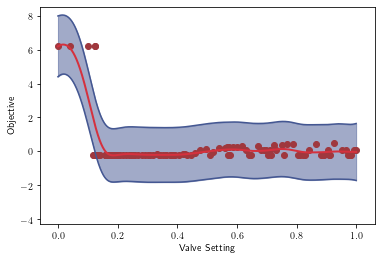

In [16]:
ax = plt.subplot(1,1,1)
plot_acquisition(ax, myBopt)

## Analyse!
So the uncertanity associated with estimates is not reducing. Couple of things might be happening here. 
    1. GP is not optimizing for the uncertanity
    2. This is the uncertanity associated with the scenario being implemented.
    3. There is something else happening in the code that I am not aware off.
    4. Check the code to make sure the objective function is reporting what you are expecting it to report.

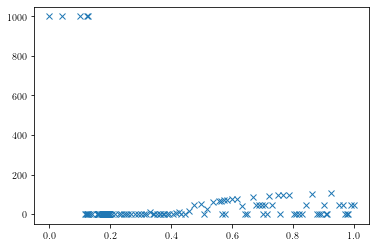

In [17]:
plt.plot(myBopt.X, myBopt.Y, 'x')

In [18]:
len(myBopt.X)

205

### Map the solution space

In [19]:
def objective_function(x, sample):
    valves = x[0][0]
    # Simulate and generate flow transformations 
    flows, overflows = single_basin(valves, inflows[str(sample)].values)
    # Convert to pandas series for ease of ops
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    # Compute performance
    reward = 0.0
    overflows = overflows.gt(0.0).any()
    if overflows:
        reward += 10**3
    flows = flows.sub(1.5)
    flows[flows < 0.0] = 0.0
    reward += flows.sum()
    return reward

x = np.linspace(0.0, 1.0, 10)
X = np.zeros((10, 20))
Y = np.zeros((10, 20))
Z = np.zeros((10, 20))
# Radomly sample them 
for j in np.linspace(0, 19, 20, dtype=int):
    for i in np.linspace(0, 9, 10, dtype=int):
        Z[i, j] = objective_function(x[i].reshape(1,1), j)
        Y[i, j] = j
        X[i, j] = i 

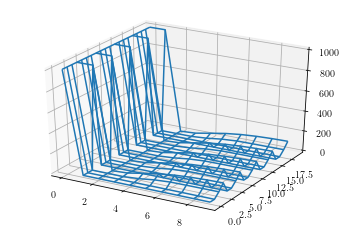

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X=X, Y=Y, Z=Z)

Thats not how it is supposed to look. Let me check the flows to verify the objective function.

In [21]:
def objective_function(x, sample):
    valves = x[0][0]
    # Simulate and generate flow transformations 
    flows, overflows = single_basin(valves, inflows[str(sample)].values)
    # Convert to pandas series for ease of ops
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    # Compute performance
    reward = 0.0
    overflows = overflows.gt(0.0).any()
    if overflows:
        reward += 10**3
    flows1 = flows.sub(1.5)
    flows1[flows1 < 0.0] = 0.0
    reward += flows1.sum()
    return reward, flows

x = np.linspace(0.0, 1.0, 30)
X = np.zeros((30, 20))
Y = np.zeros((30, 20))
Z = np.zeros((30, 20))
data = {}
# Radomly sample them 
for j in np.linspace(0, 19, 20, dtype=int):
    for i in np.linspace(0, 29, 30, dtype=int):
        Z[i, j], data[str(j)+str(i)] = objective_function(x[i].reshape(1,1), j)
        Y[i, j] = j
        X[i, j] = i 

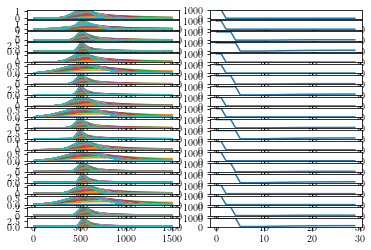

In [22]:
plt_num = 0
for q in range(0, 20):
    plt.subplot(20,2,plt_num+1)
    for i in np.linspace(0, 29, 30, dtype=int):
        plt.plot(data[str(q)+str(i)])
    
    plt.subplot(20,2,plt_num+2)
    plt.plot(Z[:,q])

    plt_num += 2 

The means estimated by the gaussian process in the above example, looks right.

## Emperically estimate mean and uncertanity.

In [23]:
mean_actions = np.mean(Z, axis=1)
std_actions = np.std(Z, axis=1)

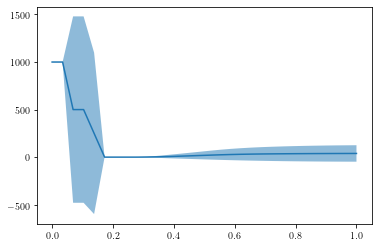

In [24]:
plt.plot(np.linspace(0, 1, 30), mean_actions)
plt.fill_between(np.linspace(0, 1, 30), mean_actions + 1.96*std_actions, mean_actions - 1.96*std_actions, alpha=0.5)

But the uncertanities are off. This could be due the GP's not optimizing for uncertanity or how the acquision function is working. 

## Train a GP using the sampled data

In [25]:
valve_opening = np.zeros((30,20))
for i in range(0, 20):
    valve_opening[:,i] = np.linspace(0.0, 1.0, 30)
# Unravel the matrix
valve_opening = np.ravel(valve_opening, order='F')
performance = np.ravel(Z, order='F')

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [27]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=100.0, noise_level_bounds=(1e-10, 1e+3))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.5).fit(valve_opening.reshape(-1,1)[:120], performance.reshape(-1,1)[:120])

In [28]:
test_x = np.linspace(0, 1.0, 30)
y_mean, y_cov = gp.predict(test_x.reshape(-1,1), return_cov=True)

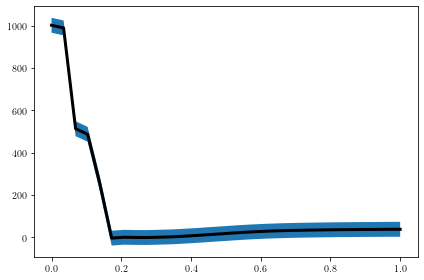

In [29]:
plt.plot(test_x, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(test_x, y_mean.reshape(30) - np.sqrt(np.diag(y_cov)), y_mean.reshape(30) + np.sqrt(np.diag(y_cov)))
plt.tight_layout()

Ok, gp is not optimized for hyperparameters. Rederive the equation.

In [30]:
gp.get_params

<bound method BaseEstimator.get_params of GaussianProcessRegressor(alpha=0.5, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=100),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)>

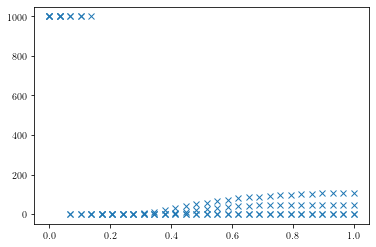

In [31]:
plt.plot(valve_opening.reshape(-1,1)[:120], performance.reshape(-1,1)[:120], 'x')

In [32]:
import GPy

In [41]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [47]:
q = GPy.models.GPRegression(valve_opening.reshape(200,1),performance.reshape(200,1),kernel)

ValueError: cannot reshape array of size 600 into shape (200,1)

In [35]:
m.optimize(messages=True)

In [36]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 3951.8614298154953
Optimization restart 2/10, f = 3944.6238148320062
Optimization restart 3/10, f = 3951.876369938819
Optimization restart 4/10, f = 3951.861980666758
Optimization restart 5/10, f = 3951.8611225416857
Optimization restart 6/10, f = 3923.4101604531807
Optimization restart 7/10, f = 3951.865388619888
Optimization restart 8/10, f = 3951.862009838558
Optimization restart 9/10, f = 3951.861100379526
Optimization restart 10/10, f = 3951.8657017596543


In [37]:
display(m)

GP_regression.,value,constraints,priors
rbf.variance,208687.08215307485,+ve,
rbf.lengthscale,0.1629037303824519,+ve,
Gaussian_noise.variance,25947.444909412454,+ve,


In [38]:
valve_opening.shape

(600,)

In [39]:
fig = m.plot()

ValueError: shape mismatch: value array of shape (200,1,1) could not be broadcast to indexing result of shape (1,200)

In [43]:
valve_opening.shape

(600,)

In [44]:
performance.shape

(600,)

In [ ]:
a, b = q.predict(x_test_new.reshape(-1,1))
a = a.reshape(100,)
b = b.reshape(100,)